<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/vae-segmentation/notebooks/Segmentation_DFC2020_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation downstream task: SEN12FLOOD

Model: ResNetUnet \\
Data: SEN12FLOOD \\
Pretrained weights: dependent on pretext tasks



### Environment setup

In [1]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@vae-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision vae-segmentation) to /tmp/pip-install-9w7vmqdi/ssl-remote-sensing_72a722e8bd004886887a24a64d7c8acd
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-9w7vmqdi/ssl-remote-sensing_72a722e8bd004886887a24a64d7c8acd
  Running command git checkout -b vae-segmentation --track origin/vae-segmentation
  Switched to a new branch 'vae-segmentation'
  Branch 'vae-segmentation' set up to track remote branch 'vae-segmentation' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 329 kB 31.7 MB/s 
     |████████████████████████████████| 20.9 MB 214 kB/s 
     |████████████████████████████████| 1.9 MB 7

In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from ssl_remote_sensing.data.dfc2020 import DFC2020
from ssl_remote_sensing.downstream_tasks.segmentation.utils import patch_first_conv, get_metrics, visualize_result
from ssl_remote_sensing.downstream_tasks.segmentation.training import train
from ssl_remote_sensing.downstream_tasks.segmentation.model import ResNetUNet
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility
from ssl_remote_sensing.constants import RANDOM_INITIALIZATION
from ssl_remote_sensing.pretext_tasks.utils import (
    load_encoder_checkpoint_from_pretext_model,
)

In [4]:
import rasterio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score
import gdown
import tarfile

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [6]:
import wandb
wandb.login()

wandb: Currently logged in as: xuemei-jiang. Use `wandb login --relogin` to force relogin


True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
RANDOM_INITIALIZATION

'random'

In [24]:
g_drive_path = "/content/drive/MyDrive/deep_learning_checkpoints"
check_point_paths = os.listdir(g_drive_path)
check_point_paths += [RANDOM_INITIALIZATION]
check_point_paths = [g_drive_path + "/" + x for x in check_point_paths]
check_point_paths

['/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_ResNet18_adam_bs2250-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/vae.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/BiGAN_encoder_ckpt_100.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/random']

### Hyperparameter setup

In [27]:
# Model Setup
class Hparams:
    def __init__(self):
        self.epochs = 2 # number of training epochs for pretext tasks
        self.seed = 1234  # randomness seed
        self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.optim = "Adam"
        self.cuda = True  # use coda
        self.transform = False
        self.split = False
        self.frozen = True

In [28]:
train_config = Hparams()

In [29]:
reproducibility(train_config)

## Data

In [12]:
dfc2020_path = '/content/drive/MyDrive/dfc2020/dfc_2020.tar.gz'

In [13]:
with tarfile.open(dfc2020_path, mode="r") as tar:
    tar.extractall(path='/content/')

In [14]:
from torch.utils.data import random_split

In [15]:
dataset = DFC2020('/content/dfc_data', subset="test", use_s1=False, use_s2lr=True, use_s2hr=True,
                 use_s2mr=True, no_savanna=True)
trainset, valset = random_split(dataset, [4102, 1026])

[Load]: 100%|██████████| 5128/5128 [00:00<00:00, 473211.10it/s]

loaded 5128 samples from the dfc2020 subset test


id: ROIs0000_test_s2_0_p1150.tif 
 input shape: (13, 256, 256) 
 label shape: (256, 256) 



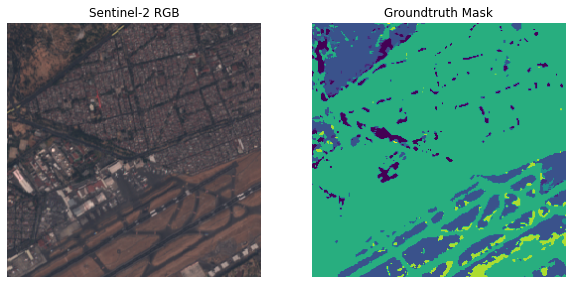

In [16]:
dataset.visualize_observation(170)

In [17]:
train_loader = DataLoader(trainset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)
val_loader = DataLoader(valset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)

In [18]:
next(iter(train_loader))["label"].shape

torch.Size([8, 256, 256])

## Segmentation Model

In [19]:
loss_fn = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


Validation Loss: 0.7694: 100%|██████████| 129/129 [00:15<00:00,  8.19it/s]

train_iou is 0.2772, val_iou is 0.3373
train_acc is 0.6676, val_acc is 0.7211



Validation Loss: 0.6750: 100%|██████████| 129/129 [00:15<00:00,  8.16it/s]


Saving Model...
train_iou is 0.3507, val_iou is 0.3563
train_acc is 0.7476, val_acc is 0.7539
Finished Training


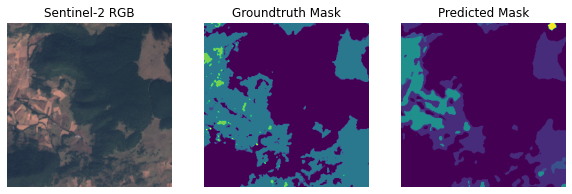

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁█
train_iou_segmentation,▁█
train_loss_segmentation,█▁
val_acc_segmentation,▁█
val_iou_segmentation,▁█
val_loss_segmentation,█▁
train_acc_segmentation,0.74759
train_iou_segmentation,0.35072
train_loss_segmentation,0.69816
val_acc_segmentation,0.75392
val_iou_segmentation,0.35629


Train Loss:   0%|          | 0/513 [00:00<?, ?it/s]


KeyboardInterrupt: ignored

In [26]:
for filename in check_point_paths:
    # Update checkpoint name
    train_config.checkpoint_name = filename
    # Load Encoder from different pre-text architectures
    encoder = load_encoder_checkpoint_from_pretext_model(
        path_to_checkpoint=filename,
    )
    patch_first_conv(encoder,13,default_in_channels=3)

    model_name = filename.split("/")[-1].split(".")[0]
    model_dir = '/content/drive/My Drive/deep_learning_segmentation_checkpoints'
    model_path = os.path.join(model_dir,f'segmentation_{model_name}.ckpt')
    # make sure the directory path exists
    assert os.path.exists(model_dir)
    

    wandb.init(
        project="ssl-remote-sensing-segmentation-dfc",
        name=model_name,
        config=train_config.__dict__,
    )

    # Model setup
    if "bigan" in train_config.checkpoint_name.lower():
        model = ResNetUNet(9,encoder = encoder, gan_encoder=True)
    else:
        model = ResNetUNet(9, encoder = encoder, gan_encoder=False)
    
    # train(model)
    train(model,train_config,train_loader,val_loader,loss_fn,device,model_path,wandb = wandb)
    
    # Initialise a UNet() model 
    if "bigan" in train_config.checkpoint_name.lower():
        bst_model = ResNetUNet(9,encoder = encoder, gan_encoder=True)
    else:
        bst_model = ResNetUNet(9, encoder = encoder, gan_encoder=False)
    # # Load pretrained weights
    bst_model.load_state_dict(torch.load(model_path))
    # # Move to device (GPU or CPU)
    bst_model.to(device)
    # visualize_result(171,bst_model)
    visualize_result(171,bst_model,valset,device,wandb = wandb,model_name = model_name)